# Approaches for Network Learning Problems

There are many different ways to approach a network machine learning problem, and it is useful to have a general sense of what you might be thinking about when you're beginning a network data science project. Here is a set of things you should be thinking about in the beginning.

- What type of network you're working with
- Which part of the network you're investigating
- What kind of preprocessing you'll need to do
- How you're understanding the statistical process that generated your network
- How you're going to represent your network in a way that lets you investigate the properties you care about easily
- What you're actually going to do once you have a good representation of your network

Let's look at each of these criteria more closely.

## What type of network you're working with

We talked earlier about the different types of networks out there. Most of this book will use **simple networks** as examples: networks whose edges don't have a direction or weight. Sometimes we'll have multiple networks. We'll also run into situations where you have additional information, called covariates, to add to node-and-edge valued data you already have. 

There are other types of networks out there which we won't discuss in this book, since techniques that use these types of networks to learn from data are underdeveloped. Just so that you know they're out there, here are some of them. Most of the time, you can find a way to turn your complicated type of network into a simple network.

- **Bipartite networks** come into play when your nodes belong to two completely distinct classes, and connections can only be established between two members of different classes. For instance, let's say you're a stock trader and you're creating a big stock network, where the nodes are stocks and the edges are the degree of covariance in stock value between them. Now, let's say that on top of that simple (albeit weighted) network, you want to cluster stocks into groups: you have your energy sector group, your entertainment sector group, and so on. The kicker is that you want your groups to be nodes *themselves*, which have edges with all of the stocks you're interested in. If you just added these groups as nodes in the original network, you lose the fact that these group nodes are qualitatively different than the other types of nodes.

- **Multilayer networks** emerge when you have a common set of nodes, but each node has multiple *types* of edges. For instance, say you're tracking the same group of users on social media networks across platforms: you have a Twitter network and an Instagram friend network containing the same people. Between any pair of nodes, there are *two* possible edges: whether they're friends on Instagram, and whether they're friends on Twitter. Fortunately, there's a simple fix for this: you can just break multilayer networks apart into separate simple networks, one for Instagram and one for Twitter.

- **Hypergraphs** are networks whose edges don't necessarily only connect two nodes. For instance, say you're at a dance party and you've brought three close friends, all of whom know each other. In addition to the pairwise relationships between your friends, you've also got a group dynamic: the relationship between you, your friend Susan, and both of your friend Tom is its own distinct thing, regardless of your one-on-one relationships with each of them. This is called a hyperedge: an edge which connects more than two nodes together. In this case, there would be a single edge between you, Susan, and Tom. Usually, to turn hypergraphs into simple graphs, you'd turn hyperedges into pairwise edges that fully connect all of the nodes involved: the single hyperedge between you, Susan, and Tom would turn into three edges that form a triangle. This allows you to use a simple model in exchange for losing some information about group relationships.

- **Dynamic networks** change over time. Think of daily snapshots of a road network, where the nodes are streets and the edges are intersections. This network will mostly be the same every day, but on some of the days, subsets of intersections might have construction going on or accidents blocking the road, temporarily deleting the edge between those two streets. We'll work with dynamic networks a little bit in this book: the main way to deal with them is to just view each snapshot as its own network, and use methods which were created to work with multiple networks.

## Which part of the network you're investigating

Once you figure out what type of network you have, you'll want to figure out exactly what you're interested in learning about. Do you care about the nodes? The edges? Do you have multiple networks, or only one? We'll get into the weeds with this in [Chapter 4](#link?). Right now, all you need to know is that there are four main avenues of investigation: treating nodes as the primary object, treating edges as the primary object, treating statistics you've calculated from your network as the primary objects, or viewing the network as a whole and treating it as a single object, to compare with another network (or networks). Most of the approaches in this book will use a node-based approach, but we'll touch on some edge-based and network-based approaches as well. We won't use calculated network statistics as much, for reasons we'll get into later.

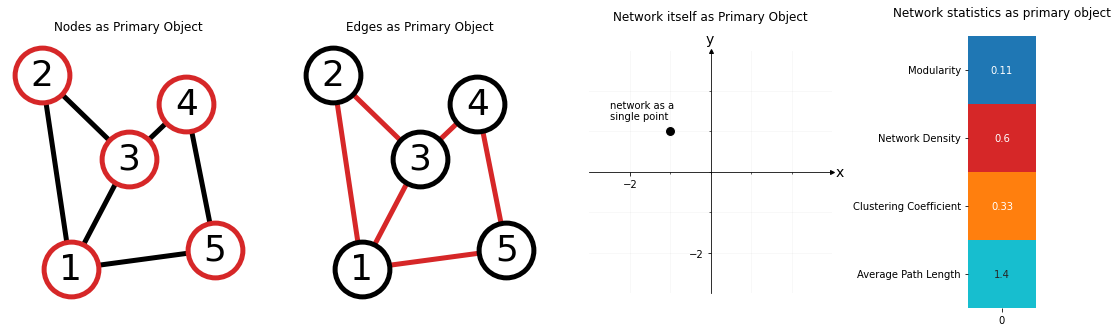

In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from graphbook_code import draw_cartesian, cmaps
from matplotlib.patches import ConnectionPatch
import functools
import pandas as pd
import seaborn as sns


def modularity(network):
    communities = nx.algorithms.community.greedy_modularity_communities(network)
    Q = nx.algorithms.community.quality.modularity(network, communities)
    return Q

def network_density(network):
    return nx.density(network)

def clustering_coefficient(network):
    return nx.transitivity(network)

def path_length(network):
    if nx.number_connected_components(network) != 1:
        # You want to make sure this still works if your network isn't fully connected!
        network = max((network.subgraph(c) for c in nx.connected_components(network)), 
                      key=len)
    return nx.average_shortest_path_length(network)

# Create network
G = nx.Graph()
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 5)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(4, 5)

# Calculate network features
network_features = []
network = G
modularity_ = modularity(network)
network_density_ = network_density(network)
clustering_coefficient_ = clustering_coefficient(network)
path_length_ = path_length(network)
features = {"Modularity": modularity_, "Network Density": network_density_, 
            "Clustering Coefficient": clustering_coefficient_, "Average Path Length": path_length_}
network_features.append(features)
df = pd.DataFrame(network_features)

# explicitly set positions
pos = {1: (0, 0), 2: (-1, 0.3), 3: (2, 0.17), 4: (4, 0.255), 5: (5, 0.03)}

options = {
    "font_size": 36,
    "node_size": 3000,
    "linewidths": 5,
    "width": 5,
    "node_color": "white",
}

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
nx.draw_networkx(G, pos,  edgecolors="tab:red", ax=axs[0], **options)
nx.draw_networkx(G, pos, edgecolors="black", edge_color="tab:red", ax=axs[1], **options)

# Set margins for the axes so that nodes aren't clipped
for ax in axs[:2]:
    ax.margins(.2)
    ax.axis("off")

axs[0].set_title("Nodes as Primary Object")
axs[1].set_title("Edges as Primary Object")
axs[2].set_title("Network itself as Primary Object", y=1.1);

# arrow
draw_cartesian(ax=axs[2])
axs[2].plot([-1], [1], marker='o', markersize=10, markerfacecolor="black", markeredgecolor="white")
axs[2].text(s="network as a \nsingle point", x=-2.5, y=1.3)

hmap = sns.heatmap(df.T, ax=axs[3], annot=True, cmap=cmaps["qualitative"], cbar=False, square=False)
hmap.set_box_aspect(4)
hmap.set_title("Network statistics as primary object", y=1.05);

## What kind of preprocessing you need to do

Although the majority of this book is about what to do after you have a fully formed network, it's important to think critically about what you need to do to a network to get it into a good form. For instance, how was the network data originally stored on your computer, and what format was it in? How noisy is your network, and is there anything you can do to clean up that noise? Are there isolated nodes which don't add any information? Do you have categorical node labels in the form of text? Do your edges have weights, and are you doing subsequent analysis that doesn't work well with edge weights?

You'll get your first exposure to this in the end-to-end network machine learning project in [Chapter 2](#link?), where you'll investigate a larval fly brain network, pulling the data from raw sources. Generally, isolated nodes cause problems when you're trying to do analysis, so unless you have a good reason not to, it's often best to remove them. It's also best practice to use numerical labels for your nodes, especially if you will be using the labels during your analysis process.

Your networks might also be directed, or have edges. This is sometimes fine, but there are cases where you'd like to just have a simple, binary network. In these cases, you'd want to either binarize your network by removing the weight information and only keeping information about whether there's an edge or not. There are also situations where you'd keep information about the *order* of weights -- meaning, which edges are higher-weighted than which other edges -- while discarding the weights themselves.

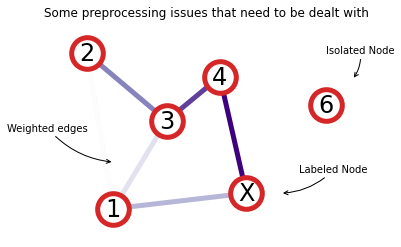

In [55]:
from graphbook_code import GraphColormap

G = nx.Graph()
G.add_edge(1, 2, weight=5)
G.add_edge(1, 3, weight=5.1)
G.add_edge(1, 5, weight=5.2)
G.add_edge(2, 3, weight=5.3)
G.add_edge(3, 4, weight=5.4)
G.add_edge(4, 5, weight=5.5)
G.add_node(6, weight=5.6)

# explicitly set positions
fig, ax = plt.subplots()
nx.relabel_nodes(G, {5: "X"}, copy=False)
pos = {1: (0, 0), 2: (-1, 0.3), 3: (2, 0.17), 4: (4, 0.255), "X": (5, 0.03), 6: (8, .2)}
edge_cmap = GraphColormap("sequential", discrete=False).palette
nx.draw_networkx(G, pos,  edge_color=range(1, 7), edge_cmap=edge_cmap, edgecolors="tab:red", **options)
ax.margins(.2)
ax.axis("off")
ax.annotate("Isolated Node", xy=(9, .25), xytext=(8, .3), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))
ax.annotate("Labeled Node", xy=(6.3, .03), xytext=(7, .07), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))
ax.annotate("Weighted edges", xy=(0, .09), xytext=(-4, .15), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2"));

ax.set_title("Some preprocessing issues that need to be dealt with");

## Understanding the statistical process that generated your network

A key concept that you'll see throughout this book, especially if you are uninitiated in statistics, is viewing every network as simply an observation which resulted from a data-generating process. What you're essentially doing is trying to reconstruct the properties of that data-generating process using the observation and data you have. This idea is ubiquitous and fundamental throughout statistics.

We'll get into the different types of ways you can model a data-generating process, and the types of processes out there, heavily in [Chapter 5](#link?). For now, here's a brief summary of the types of models you might consider, given the network data that you observe.

### The Erdös-Rényi Model

The ER random network model is the simplest around, and is probably the most straightforward to understand. Under this model, for any two nodes in our network, there is some probability that they'll have an edge (say, $p = 0.3$). That means that when you observe a network whose generating process was Erdös-Rényi, each edge has the same 30% chance of existing, regardless of which nodes you're looking at. It would be unlikely to find groups or communities, or even any structure at all, in an ER model. Erdös-Rényi networks have well-defined mathematical properties: we know how many edges on average the nodes should be expected to have, for instance.

Text(0.5, 1.0, '')

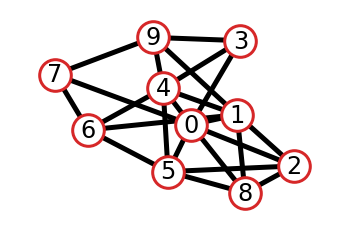

In [56]:
from graspologic.simulations import er_np

A = er_np(10, .5)
G = nx.from_numpy_array(A)
options = {
    "font_size": 24,
    "node_size": 1000,
    "linewidths": 3,
    "width": 5,
    "node_color": "white",
}

nx.draw_networkx(G, pos=nx.spring_layout(G), edgecolors="tab:red", **options)
ax = plt.gca()
ax.margins(.2)
ax.axis("off");
ax.set_title("");

### The Stochastic Block Model

An SBM is a step up in complexity from the ER model, and we'll be using it heavily throughout this book. It builds on top of the ER model in complexity: The basic idea is that, in addition to each edge being associated with a probability, each node is also associated with a community, and edge probabilities can change depending on the community your node belongs to. When we're trying to reconstruct community membership, we'll usually assume that our data-generating process happened as the result of some kind of SBM. 

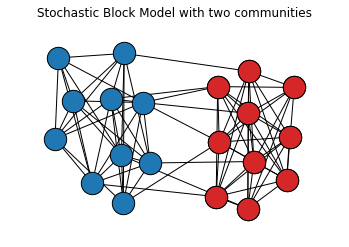

In [110]:
from graspologic.simulations import sbm

np.random.seed(5)
A, labels = sbm([10, 10], return_labels=True, p=np.array([[.8, .1,], [ .1, .8]]))
G = nx.from_numpy_array(A)
options = {
    "node_size": 500,
    "linewidths": 1,
    "edgecolors": "black",
}

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=False, node_color="tab:blue", **options)
nx.draw_networkx_nodes(G, pos=pos, nodelist=list(range(10, 20)), node_color="tab:red", **options)
ax = plt.gca()
ax.margins(.2)
ax.axis("off");
ax.set_title("Stochastic Block Model with two communities");

### Random Dot Product Graphs

The ER model and the SBM can both be thought of as particular cases of a Random Dot Product Graph. The RDPG is a little bit harder-to-understand, since it uses a few concepts from linear algebra at its core, with the advantage of being much more dynamic. The basic idea is that, rather than being associated with a probability, each node is associated with a *latent position*: a vector with however many entries you want. The edge probability for a given pair of nodes is given by the dot product between their latent positions. In an ER model, every node has the same latent position; in an SBM, every node belonging to the same community has the same latent position.

When we find representations for networks throughout this book, an overarching theme will be assuming that the networks were drawn from an RDPG under the hood, and estimating these latent positions will be central to a large portion of its content.

### Multiple Network Models

Sometimes you'll be in a situation where, instead of having one network, you have more than one, and there's some type of dependency that makes it useful to have a single data-generating process whose data is *groups* of networks, rather than individual networks. There are a couple multiple-network models that you'll see in this group:
- The Joint RDPG model simply assumes that each of the networks it generated are independent and generated by the same latent positions. You're implictly assuming that all of your networks are RDPGs and have latent positions.
- The COSIE (Common Edge Independent Subspace) model is a bit more dynamic: it assumes that there is a shared overall structure between the data-generating process for all of your networks, but that there can be variation on a per-network basis. The details of this involve a fair amount of linear algebra, so we'll save it for [Chapter 5](#link?). Just know that it exists.

### Network Models with Covariates

The last type of network model that you'll see in this book come into play when you have covariates, which we've already talked about a bit: an extra set of features for each node. 

## How you're going to represent your network

Once you've figured out which statistical process best represents the network you have, you're going to want to represent your network in some way that makes whatever questions that you're planning to address easier. This means taking your network or networks, which exist as sets of nodes and edges, and representing it or them a different way, usually as a set of points embedded into coordinate space. What these points represent changes depending on what part of the network you're investigating: points could represent individual nodes, groups of nodes, entire networks, or even edges in some rare cases. You can sometimes keep your network as a set of nodes and edges, and do your analysis that way -- but we'll usually do our work using these embedding methods. 

We'll go into more depth about the different types of embedding methods that you should use for different types of models in [Chapter 6](#link?).

## What you're going to do when you have a good representation

Once you have a good representation of your network or networks, the fun begins. You get to actually learn something about the underlying system. The reason that we come up with these statistical network models and representations is that we want to figure out how we can tease out characteristics of the underlying system. The way you tease out these characteristics is that you use representations of the networks you obtain to describe attributes about the statistical network models you chose to use. You then use the mathematical properties of these representations to define precisely how confident you are about underlying questions, or "inference tasks", which you might be wondering about the underlying statistical model. For instance, if you see see a network, is there any discernable structure to it? If so, how discernable is the structure? If you see two networks, you might be wondering, are these networks the same, or are they different? If they are different, how do they differ? 

In network machine learning, we care very much about precision, so knowing how to quantify how certain you are about characteristics of the underlying system given the system we observed is critical. You will learn about some things you can do with representations of your networks to learn about the underlying system in [Chapter 8](#link?), [Chapter 9](#link?), and [Chapter 10](#link?). It is important to clarify that what you decide to do with your network once you obtain a reasonable representation is an open-ended question: we only show you a small subset of the limitless possible applications of network machine learning in this book, but we could go on forever about extensions and other steps you could take in this rapidly advancing field. Network machine learning is a growing science discipline, and we believe this book will give you a firm enough grasp of the basics to jump in and keep pushing the field forward.